Classification threshold: 75.63 Million USD
              Model  Accuracy  Precision  Recall      F1  ROC_AUC
0          CatBoost    0.9617     0.9073  0.9384  0.9226   0.9925
1          LightGBM    0.9717     0.9329  0.9521  0.9424   0.9950
2      RandomForest    0.9683     0.9441  0.9247  0.9343   0.9923
3  GradientBoosting    0.9717     0.9161  0.9726  0.9435   0.9938
4           XGBoost    0.9683     0.9097  0.9658  0.9369   0.9930


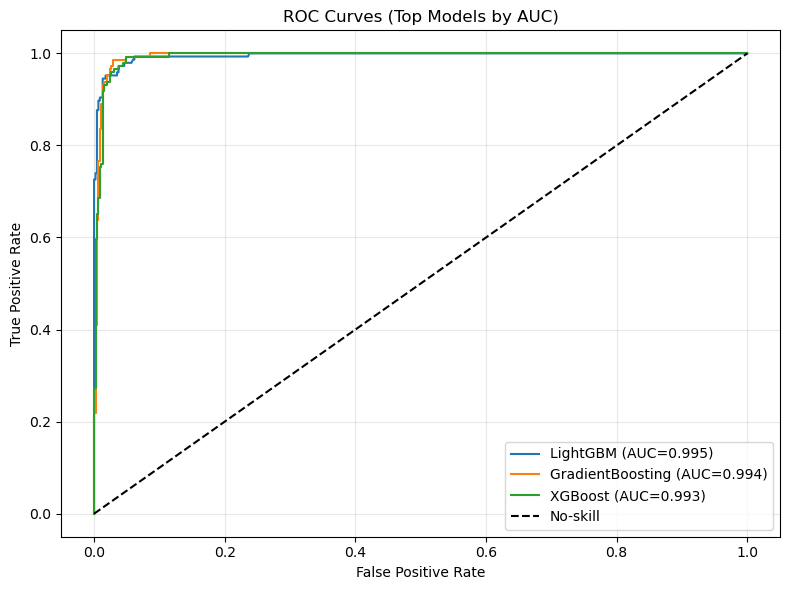

In [2]:
# Step5_additional_metrics.ipynb

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# ---------------------------
# Suppress warnings globally
# ---------------------------
warnings.filterwarnings("ignore")

# Silence joblib loky backend warnings
import joblib
joblib.parallel_backend('loky', inner_max_num_threads=1)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split

# ---------------------------
# Paths
# ---------------------------
PROJECT_ROOT = r"C:\Users\uthay\Desktop\CyberThreats_FinancialLoss_Prediction_ML"
RAW_DATA_PATH = os.path.join(PROJECT_ROOT, "data", "raw", "Global_Cybersecurity_Threats_2015-2024 (1).csv")
PROCESSED_PATH = os.path.join(PROJECT_ROOT, "data", "processed")
MODEL_PATH = os.path.join(PROJECT_ROOT, "models")
OUTPUT_PATH = os.path.join(PROJECT_ROOT, "outputs")
os.makedirs(OUTPUT_PATH, exist_ok=True)

# ---------------------------
# Load raw dataset
# ---------------------------
df_raw = pd.read_csv(RAW_DATA_PATH)

# Feature engineering (same as Step4)
numeric_features = ['Number of Affected Users', 'Incident Resolution Time (in Hours)']
categorical_features = ['Attack Type', 'Target Industry', 'Attack Source', 'Security Vulnerability Type']
target = 'Financial Loss (in Million $)'

df_raw['AttackType_TargetIndustry'] = df_raw['Attack Type'] + "_" + df_raw['Target Industry']
categorical_features.append('AttackType_TargetIndustry')

df_raw['Loss_per_User'] = df_raw[target] / (df_raw['Number of Affected Users'] + 1)
numeric_features.append('Loss_per_User')

X = df_raw[numeric_features + categorical_features]
y = df_raw[target]

# Same train/test split as Step4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# Load tuned models (5 models only)
# ---------------------------
tuned_models = {
    "CatBoost": "CatBoost_tuned.joblib",
    "LightGBM": "LightGBM_tuned.joblib",
    "RandomForest": "RandomForest_tuned.joblib",
    "GradientBoosting": "GradientBoosting_tuned.joblib",
    "XGBoost": "XGBoost_tuned.joblib"
}

y_pred_dict = {}
for name, fname in tuned_models.items():
    model = joblib.load(os.path.join(MODEL_PATH, fname))
    # suppress feature name warnings by ignoring them globally
    y_pred_dict[name] = model.predict(X_test)

# ---------------------------
# Threshold selection (75th percentile of losses)
# ---------------------------
threshold = np.percentile(df_raw[target].values, 75)
print(f"Classification threshold: {threshold:.2f} Million USD")

y_true_cls = (y_test >= threshold).astype(int)

# ---------------------------
# Compute classification metrics
# ---------------------------
classification_results = []
for name, y_pred in y_pred_dict.items():
    y_pred_cls = (y_pred >= threshold).astype(int)
    acc = accuracy_score(y_true_cls, y_pred_cls)
    prec = precision_score(y_true_cls, y_pred_cls, zero_division=0)
    rec = recall_score(y_true_cls, y_pred_cls, zero_division=0)
    f1 = f1_score(y_true_cls, y_pred_cls, zero_division=0)
    auc = roc_auc_score(y_true_cls, y_pred)

    classification_results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": auc
    })

cls_df = pd.DataFrame(classification_results).round(4)
print(cls_df)

# Save metrics table
cls_df.to_csv(os.path.join(PROCESSED_PATH, "classification_metrics_step5.csv"), index=False)

# ---------------------------
# ROC Curve (Top 3 models by AUC)
# ---------------------------
top_models = cls_df.sort_values("ROC_AUC", ascending=False).head(3)["Model"].tolist()

plt.figure(figsize=(8, 6))
for name in top_models:
    y_pred = y_pred_dict[name]
    fpr, tpr, _ = roc_curve(y_true_cls, y_pred)
    auc = roc_auc_score(y_true_cls, y_pred)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="No-skill")
plt.title("ROC Curves (Top Models by AUC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, "roc_curve_step5.png"))
plt.show()